In [2]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# **CONFIG BLOCK**

In [3]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15

# **DATA PREPROCESSING, MODEL BUILDING AND TRAINING (Training set: Augmentation Applied)**


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          
    width_shift_range=0.1,      
    height_shift_range=0.1,     
    zoom_range=0.1,             
    shear_range=0.1,            
    horizontal_flip=True,       
    fill_mode='nearest',
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST)
)

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# BUILD VGG16 FROM SCRATCH
model = Sequential([
   
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(*IMG_SIZE, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

  
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

 
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])


# COMPILE
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# TRAIN
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763576483.589403      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763576491.062351     129 service.cc:148] XLA service 0x796ad8004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763576491.063492     129 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763576491.804049     129 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763576512.375198     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.3493 - loss: 1.0995

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 819ms/step - accuracy: 0.3492 - loss: 1.0995 - val_accuracy: 0.3596 - val_loss: 1.0973
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4084 - loss: 1.0399

77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 500ms/step - accuracy: 0.4099 - loss: 1.0382 - val_accuracy: 0.6577 - val_loss: 0.6849
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6766 - loss: 0.7057

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 492ms/step - accuracy: 0.6768 - loss: 0.7050 - val_accuracy: 0.7612 - val_loss: 0.5516
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7627 - loss: 0.5635

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 494ms/step - accuracy: 0.7627 - loss: 0.5634 - val_accuracy: 0.7923 - val_loss: 0.4910
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7870 - loss: 0.5002

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.7870 - loss: 0.5000 - val_accuracy: 0.8153 - val_loss: 0.4280
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 415ms/step - accuracy: 0.8191 - loss: 0.4667 - val_accuracy: 0.8147 - val_loss: 0.4503
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8325 - loss: 0.4222

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 493ms/step - accuracy: 0.8324 - loss: 0.4223 - val_accuracy: 0.8544 - val_loss: 0.3429
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 409ms/step - accuracy: 0.8328 - loss: 0.4149 - val_accuracy: 0.8412 - val_loss: 0.4004
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8386 - loss: 0.4215

77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.8385 - loss: 0.4214 - val_accuracy: 0.8774 - val_loss: 0.3125
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 414ms/step - accuracy: 0.8535 - loss: 0.3603 - val_accuracy: 0.8608 - val_loss: 0.3388
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step - accuracy: 0.8322 - loss: 0.3936 - val_accuracy: 0.8671 - val_loss: 0.3229
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 414ms/step - accuracy: 0.8446 - loss: 0.3936 - val_accuracy: 0.8769 - val_loss: 0.3156



# **EVALUATION AND METRICS**


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.8317 - loss: 0.3766

Test Accuracy: 87.28%
Test Loss: 0.3086
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.8887    0.8096    0.8473       562
         Normal     0.8365    0.8432    0.8398       625
Viral Pneumonia     0.8975    0.9709    0.9328       550

       accuracy                         0.8728      1737
      macro avg     0.8742    0.8746    0.8733      1737
   weighted avg     0.8727    0.8728    0.8717      1737



<Figure size 800x600 with 0 Axes>

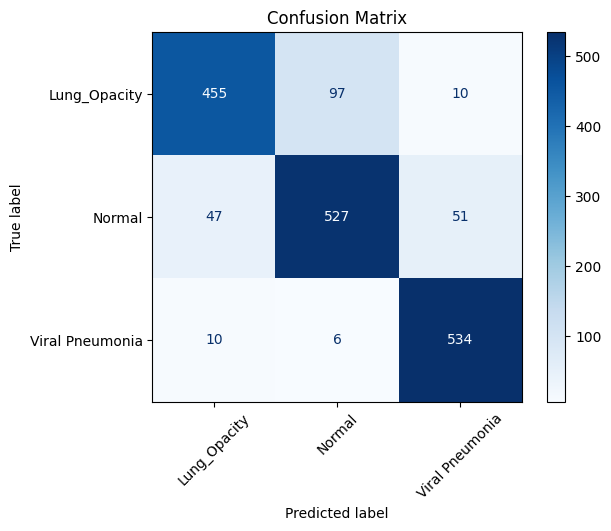

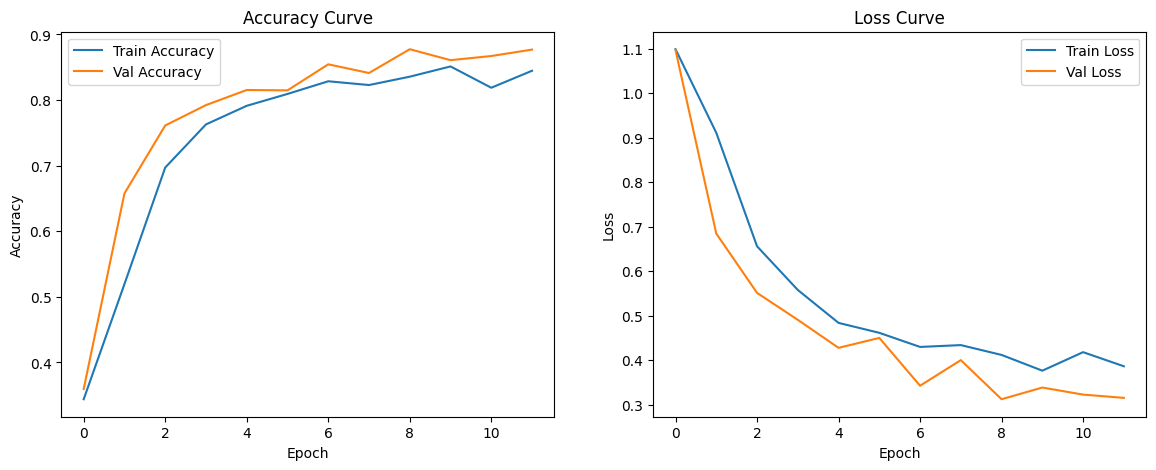

In [5]:
# EVALUATE
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score

# True labels
Y_true = test_gen.classes

# Predicted labels
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Class labels
class_labels = list(test_gen.class_indices.keys())

print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()


# TRAINING CURVES
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()